In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sklm
import xgboost as xgb
import matplotlib

In [22]:
train = pd.read_csv('train.csv', parse_dates = ['date'])
test = pd.read_csv('test.csv', parse_dates = ['date'])
submissions = pd.read_csv('SampleSubmission.csv')
vd = pd.read_csv('VariableDefinitionsHotspot.csv')

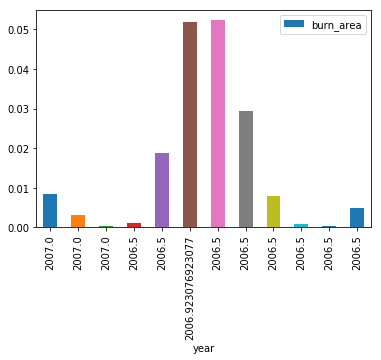

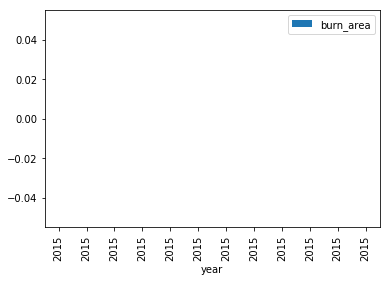

In [23]:
# Date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

# Plotting mean burn_area for each month - very strong mid-year peak (dry season)
train.groupby('month').mean().reset_index().plot(y='burn_area', x='year', kind='bar')

# Date variables
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year

# Plotting mean burn_area for each month - very strong mid-year peak (dry season)
test.groupby('month').mean().reset_index().plot(y='burn_area', x='year', kind='bar')

In [24]:
print(train.columns)

train = train.drop(['population_density', 'ID', 'date', 'climate_swe', 'landcover_0',
                    'landcover_1', 'landcover_2', 'landcover_3', 'landcover_5', 'landcover_6',
                    'landcover_7', 'landcover_8'], axis=1)
test = test.drop(['population_density', 'ID', 'burn_area', 'date', 'climate_swe', 'landcover_0','landcover_1', 
                  'landcover_2', 'landcover_3', 'landcover_5', 'landcover_6','landcover_7', 'landcover_8'], axis=1)

Index(['ID', 'area', 'date', 'lat', 'lon', 'burn_area', 'climate_aet',
       'climate_def', 'climate_pdsi', 'climate_pet', 'climate_pr',
       'climate_ro', 'climate_soil', 'climate_srad', 'climate_swe',
       'climate_tmmn', 'climate_tmmx', 'climate_vap', 'climate_vpd',
       'climate_vs', 'elevation', 'landcover_0', 'landcover_1', 'landcover_2',
       'landcover_3', 'landcover_4', 'landcover_5', 'landcover_6',
       'landcover_7', 'landcover_8', 'population_density', 'precipitation',
       'month', 'year'],
      dtype='object')


In [25]:
print(train.shape)
print(test.shape)

(626644, 22)
(137556, 21)


In [26]:
print(train.columns)
print(test.columns)

Index(['area', 'lat', 'lon', 'burn_area', 'climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_tmmn', 'climate_tmmx',
       'climate_vap', 'climate_vpd', 'climate_vs', 'elevation', 'landcover_4',
       'precipitation', 'month', 'year'],
      dtype='object')
Index(['area', 'lat', 'lon', 'climate_aet', 'climate_def', 'climate_pdsi',
       'climate_pet', 'climate_pr', 'climate_ro', 'climate_soil',
       'climate_srad', 'climate_tmmn', 'climate_tmmx', 'climate_vap',
       'climate_vpd', 'climate_vs', 'elevation', 'landcover_4',
       'precipitation', 'month', 'year'],
      dtype='object')


In [27]:
Labels = np.array(train['burn_area'])
print(Labels)

[0.00368827 0.         0.         ... 0.         0.         0.        ]


In [28]:
train = train.drop('burn_area', axis=1)

In [29]:
Features = np.array(train)
test_enc = np.array(test)

In [30]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(Features[:, :])
Features[:, :] = scaler.transform(Features[:, :])
print(Features[:, :])

[[-1.73159757  0.43753111  1.85451289 ...  0.1322863  -0.75212307
  -1.68075649]
 [-1.73069097  0.49456614  1.85383075 ...  0.04842358 -0.75212307
  -1.68075649]
 [-1.72978438  0.43650345  1.80403446 ...  0.23004017 -0.75212307
  -1.68075649]
 ...
 [ 1.72978438  1.48445787 -2.34861303 ...  1.04469196  1.57520115
   1.60372824]
 [ 1.73069097  1.54174981 -2.34565709 ...  0.77124435  1.57520115
   1.60372824]
 [ 1.73159757  1.5450897  -2.39522601 ...  0.63133742  1.57520115
   1.60372824]]


In [31]:
scaler1 = preprocessing.StandardScaler().fit(test_enc[:, :])
test_enc[:, :] = scaler1.transform(test_enc[:, :])
#print(test_enc[:, :])

In [32]:
import numpy.random as nr
import sklearn.model_selection as ms
## Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 0.2)
x_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

In [33]:
indx1 = range(x_train.shape[0])
indx1 = ms.train_test_split(indx1, test_size = 0.2)
x_train1 = x_train[indx1[0],:]
y_train1 = np.ravel(y_train[indx1[0]])
x_train_val = x_train[indx1[1],:]
y_train_val = np.ravel(y_train[indx1[1]])

In [34]:
xg_reg = xgb.XGBRegressor(objective = 'reg:logistic', n_estimators = 400, seed = 123, max_depth = 8,
                           learning_rate=0.1, booster = 'gbtree', base_score = 0.7, subsample = 0.8,
                           reg_lambda = 0.03)

eval_set = [(x_train1, y_train1), (x_test, y_test)]
xg_reg.fit(x_train1, y_train1, eval_metric="rmse", eval_set=eval_set, verbose=True, early_stopping_rounds = 10)

[0]	validation_0-rmse:0.61490	validation_1-rmse:0.61527
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.55200	validation_1-rmse:0.55233
[2]	validation_0-rmse:0.49653	validation_1-rmse:0.49679
[3]	validation_0-rmse:0.44738	validation_1-rmse:0.44748
[4]	validation_0-rmse:0.40352	validation_1-rmse:0.40349
[5]	validation_0-rmse:0.36421	validation_1-rmse:0.36421
[6]	validation_0-rmse:0.32889	validation_1-rmse:0.32895
[7]	validation_0-rmse:0.29721	validation_1-rmse:0.29730
[8]	validation_0-rmse:0.26875	validation_1-rmse:0.26882
[9]	validation_0-rmse:0.24323	validation_1-rmse:0.24329
[10]	validation_0-rmse:0.22024	validation_1-rmse:0.22029
[11]	validation_0-rmse:0.19954	validation_1-rmse:0.19964
[12]	validation_0-rmse:0.18092	validation_1-rmse:0.18104
[13]	validation_0-rmse:0.16428	validation_1-rmse:0.16434
[14]	validation_0-rmse:0.14922	validation_1-rmse:0.14

[141]	validation_0-rmse:0.02447	validation_1-rmse:0.02717
[142]	validation_0-rmse:0.02436	validation_1-rmse:0.02709
[143]	validation_0-rmse:0.02415	validation_1-rmse:0.02694
[144]	validation_0-rmse:0.02411	validation_1-rmse:0.02690
[145]	validation_0-rmse:0.02399	validation_1-rmse:0.02681
[146]	validation_0-rmse:0.02383	validation_1-rmse:0.02668
[147]	validation_0-rmse:0.02378	validation_1-rmse:0.02665
[148]	validation_0-rmse:0.02374	validation_1-rmse:0.02662
[149]	validation_0-rmse:0.02365	validation_1-rmse:0.02658
[150]	validation_0-rmse:0.02355	validation_1-rmse:0.02651
[151]	validation_0-rmse:0.02349	validation_1-rmse:0.02649
[152]	validation_0-rmse:0.02336	validation_1-rmse:0.02641
[153]	validation_0-rmse:0.02324	validation_1-rmse:0.02633
[154]	validation_0-rmse:0.02323	validation_1-rmse:0.02633
[155]	validation_0-rmse:0.02317	validation_1-rmse:0.02630
[156]	validation_0-rmse:0.02303	validation_1-rmse:0.02622
[157]	validation_0-rmse:0.02294	validation_1-rmse:0.02618
[158]	validati

[283]	validation_0-rmse:0.01756	validation_1-rmse:0.02323
[284]	validation_0-rmse:0.01752	validation_1-rmse:0.02321
[285]	validation_0-rmse:0.01751	validation_1-rmse:0.02321
[286]	validation_0-rmse:0.01747	validation_1-rmse:0.02320
[287]	validation_0-rmse:0.01745	validation_1-rmse:0.02319
[288]	validation_0-rmse:0.01742	validation_1-rmse:0.02319
[289]	validation_0-rmse:0.01741	validation_1-rmse:0.02318
[290]	validation_0-rmse:0.01739	validation_1-rmse:0.02318
[291]	validation_0-rmse:0.01737	validation_1-rmse:0.02317
[292]	validation_0-rmse:0.01735	validation_1-rmse:0.02316
[293]	validation_0-rmse:0.01734	validation_1-rmse:0.02316
[294]	validation_0-rmse:0.01731	validation_1-rmse:0.02315
[295]	validation_0-rmse:0.01728	validation_1-rmse:0.02314
[296]	validation_0-rmse:0.01724	validation_1-rmse:0.02313
[297]	validation_0-rmse:0.01723	validation_1-rmse:0.02312
[298]	validation_0-rmse:0.01723	validation_1-rmse:0.02312
[299]	validation_0-rmse:0.01718	validation_1-rmse:0.02310
[300]	validati

XGBRegressor(base_score=0.7, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=400, n_jobs=0, num_parallel_tree=1,
       objective='reg:logistic', random_state=123, reg_alpha=0,
       reg_lambda=0.03, scale_pos_weight=1, seed=123, subsample=0.8,
       tree_method=None, validate_parameters=False, verbosity=None)

In [35]:
preds = xg_reg.predict(x_train_val)

In [36]:
preds

array([3.2687869e-06, 3.9309266e-06, 1.1686415e-05, ..., 5.9675676e-07,
       3.5607456e-05, 7.4012714e-06], dtype=float32)

In [43]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train_val, preds)**0.5

0.02363445290068684

In [38]:
test_pred = xg_reg.predict(test_enc)

In [39]:
test.shape

(137556, 21)

In [40]:
submissions.Prediction = test_pred

In [41]:
submissions.head()

,ID,Prediction
0,0_2014-01-01,0.189204
1,1_2014-01-01,0.164399
2,2_2014-01-01,0.278334
3,3_2014-01-01,0.226303
4,4_2014-01-01,0.263774


In [42]:
submissions.to_csv('HotspotSubmission5.csv', index=False)